In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from collections import Counter

from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from scipy.interpolate import interp1d
from imblearn.over_sampling import SMOTE

In [7]:
reviews = pd.read_csv("preprocessed_data.csv")

In [8]:
reviews.head()

,reviewerID,asin,reviewerName,overall,unixReviewTime,reviews,Sentiment,year,month,day,helpful_review,cleaned_reviewText
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...",5,1393545600,"Not much to write about here, but it does exac...",2,2014,2,28,0.00,much write exactly supposed filters pop sounds...
1,A14VAT5EAX3D9S,1384719342,Jake,5,1363392000,The product does exactly as it should and is q...,2,2013,3,16,0.93,product exactly quite affordablei realized dou...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",5,1377648000,The primary job of this device is to block the...,2,2013,8,28,1.00,primary job device block breath would otherwis...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",5,1392336000,Nice windscreen protects my MXL mic and preven...,2,2014,2,14,0.00,nice windscreen protects mxl mic prevents pops...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,5,1392940800,This pop filter is great. It looks and perform...,2,2014,2,21,0.00,pop filter great looks performs like studio fi...


In [9]:
review_features = reviews.copy()
review_features = review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...
2,The primary job of this device is to block the...
3,Nice windscreen protects my MXL mic and preven...
4,This pop filter is great. It looks and perform...


In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (2,2))
# TF-IDF feature matrix
X = tfidf_vectorizer.fit_transform(review_features['reviews'])
X.shape

(10261, 5000)

In [11]:
#Getting the target variable(encoded)
y = reviews['Sentiment']
y.shape

(10261,)

In [12]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_resampled)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


In [13]:
## Splitting the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state=0)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
#creating the objects
logreg = LogisticRegression(random_state=0)
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
svc = SVC()
nb = BernoulliNB()
rf = RandomForestClassifier()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2:'KNN', 3:'SVC', 4:'Naive Bayes', 5: 'Random Forest'}
cv_models = [logreg, dt, knn, svc, nb, rf]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()))

Logistic Regression Test Accuracy: 0.8827600213343052
Decision Tree Test Accuracy: 0.8214584389134689
KNN Test Accuracy: 0.8792515341149585
SVC Test Accuracy: 0.8796413976627168
Naive Bayes Test Accuracy: 0.779063530296042
Random Forest Test Accuracy: 0.881200567143272


In [18]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state = 0), param_grid, cv = 5, verbose = 0,n_jobs = -1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:", best_model.score(X_test,y_test))

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_sol

LogisticRegression(C=6866.488450042998, random_state=0)
The mean accuracy of the model is: 0.981159955670484


In [19]:
logreg = LogisticRegression(C = 6866.498, random_state = 0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


Confusion matrix, without normalization


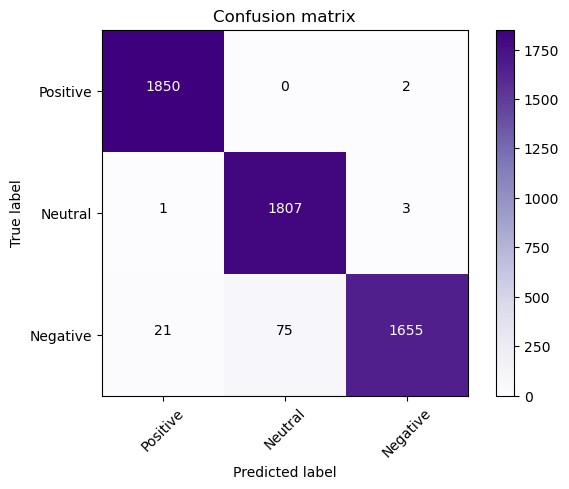

In [22]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Positive','Neutral','Negative'])

In [23]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1852
           1       0.96      1.00      0.98      1811
           2       1.00      0.95      0.97      1751

    accuracy                           0.98      5414
   macro avg       0.98      0.98      0.98      5414
weighted avg       0.98      0.98      0.98      5414



In [26]:
import joblib
joblib.dump(logreg, "data/models/sentiment_model.pkl")
joblib.dump(tfidf_vectorizer, "data/models/tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']